In [6]:
import numpy as np
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage

# Skimage
import skimage
from skimage.io import imread, imread_collection, imshow_collection, imsave, collection
from skimage.filters import sobel,sobel_h,sobel_v, scharr, threshold_otsu,threshold_adaptive,threshold_minimum, gaussian, laplace
from skimage.measure import find_contours, label, regionprops
from skimage.morphology import convex_hull_image, dilation, erosion, opening,medial_axis,thin,remove_small_objects,binary_erosion
from skimage.transform import SimilarityTransform, warp, rotate

import skimage.graph

def load_folder_as_np(folder_path):
    V = imread_collection(get_filenames(folder_path))
    return collection.concatenate_images(V)

def get_filenames(folder_path):
    return skimage.io.collection.glob(folder_path+"*.tif")

def largest_component(img):
    labels,N = label(img > 0, return_num=True)
    out_img = np.copy(img)
    props = regionprops(labels)
    sizes = [props[i].area for i in range(N)]
    if len(sizes) == 0:
        return 0
    out_img[labels != np.argmax(sizes)+1] = 0
    return out_img

def make_offsets(d, fully_connected):

    if fully_connected:
        mask = np.ones([3]*d, dtype=np.uint8)
        mask[tuple([1]*d)] = 0
    else:
        mask = np.zeros([3]*d, dtype=np.uint8)
        for i in range(d):
            indices = [1]*d
            indices[i] = (0, -1)
            mask[tuple(indices)] = 1
    offsets = []
    for indices, value in np.ndenumerate(mask):
        if value == 1:
            indices = np.array(indices) - 1
            offsets.append(indices)
    return offsets


from skimage.graph import MCP, MCP_Geometric, MCP_Connect, MCP_Flexible
#A = np.zeros(down3.shape)

#class MCP_Flexible:
def travel_cost(self, old_cost, new_cost, offset_length):
#def _update_node(index, new_index, offset_length):
    print('hi')
    return new_cost

#MCP_Flexible.travel_cost = travel_cost

In [2]:
# Load data
data = load_folder_as_np("/Users/eithunm/Projects/barley/data/barley1/")
print(data.shape)

(1512, 254, 240)


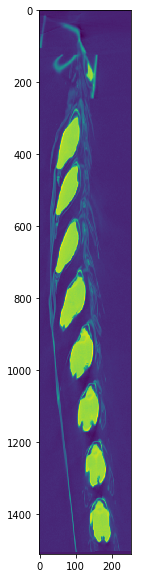

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(data[:,:,100])

##############

In [4]:
# Downsample
down3 = scipy.ndimage.zoom(data,(0.3,0.3,0.3))

/Users/eithunm/anaconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


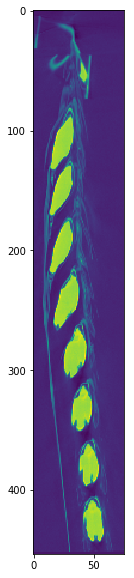

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(down3[:,:,30])

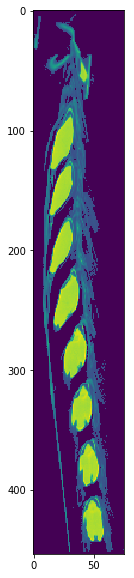

In [9]:
# Threshold to find lowest pixel
plt.figure(figsize=(10,10))
img_thresh = np.copy(down3)
img_thresh[img_thresh < threshold_otsu(img_thresh)/2.2] = 0
plt.imshow(img_thresh[:,:,30])

63360.0 0.0
2.0853630853172265e+48 5.815914880532787e+22


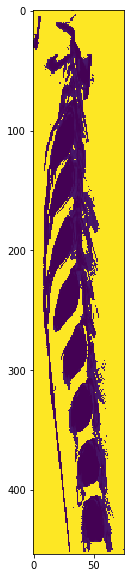

In [179]:
#img = np.array(down3,'float64')
img = np.array(img_thresh,'float')

plt.figure(figsize=(10,10))
print(np.max(img),np.min(img))

# Power transform
#img = np.power(1+10e-5,np.abs(np.max(img) - img))
img = np.power(np.abs(np.max(img) - img),10)

img[img < 10e-10] = np.max(img) *2
#img = img/10e10

print(np.max(img),np.min(img))
plt.imshow(img[:,:,30])

In [180]:
foreground_points = np.array(np.where(img_thresh)).T
print(foreground_points)

[[  0  27  34]
 [  0  27  35]
 [  0  27  36]
 ...
 [452  64  63]
 [452  65  60]
 [452  65  63]]


In [181]:
start = [  0,  27,  34]
m = skimage.graph.MCP_Flexible(img, fully_connected=True)
costs, traceback_array = m.find_costs([start])

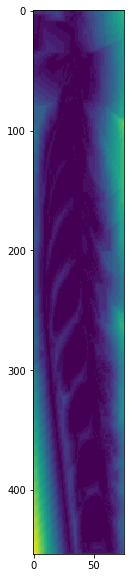

In [182]:
plt.figure(figsize=(10,10))
#tmp = np.copy(costs[:,:,30])
#T = threshold_otsu(tmp)
#tmp[tmp > T] = 0
#plt.imshow(tmp)
plt.imshow(costs[:,:,30])

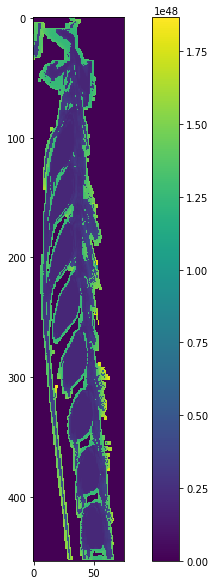

In [183]:
plt.figure(figsize=(10,10))
adj = np.copy(costs)#**0.5
adj[adj > threshold_otsu(adj)*0.2] = 0
#adj[img_thresh == 0] = 0
p = plt.imshow(adj[:,:,30])
plt.colorbar(p)

(array([152438., 161988.,  18781.,   2915.,   1486.,    884.,  97066.,
         97254.,  24614.,   8974.]),
 array([4.14894441e+35, 2.25841319e+36, 4.10193193e+36, 5.94545068e+36,
        7.78896943e+36, 9.63248818e+36, 1.14760069e+37, 1.33195257e+37,
        1.51630444e+37, 1.70065632e+37, 1.88500819e+37]),
 <a list of 10 Patch objects>)

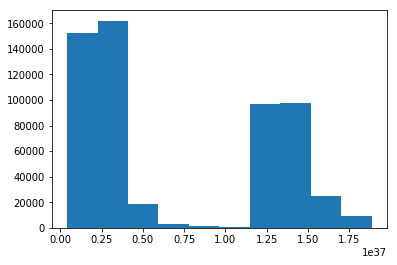

In [146]:
plt.hist(adj[adj!=0].flatten())

In [81]:
# Get indices of sorted array in descending order
ind = np.unravel_index(np.argsort(-costs, axis=None), costs.shape)
indices = np.array(ind).T

In [78]:
offsets = make_offsets(3, True)
subtreeSize = np.copy(img)
#subtreeSize = np.power(np.array(down3,'float'),10)
subtreeSizeOnes = np.ones(down3.shape)
len_i = len(indices)
for i in range(len_i):
    if i % 100000 == 0:
        print(str(round(100*i/len_i,2)),"percent")
    current_index = tuple(indices[i])
    pred = indices[i] - offsets[traceback_array[current_index]]
    subtreeSize[tuple(pred)] += subtreeSize[current_index]
    subtreeSizeOnes[tuple(pred)] += subtreeSizeOnes[current_index]
    #subtreeSize[current_index] += subtreeSize[tuple(pred)]

0.0 percent
4.03 percent
8.05 percent
12.08 percent
16.1 percent
20.13 percent
24.15 percent
28.18 percent
32.2 percent
36.23 percent
40.25 percent
44.28 percent
48.3 percent
52.33 percent
56.35 percent
60.38 percent
64.4 percent
68.43 percent
72.46 percent
76.48 percent
80.51 percent
84.53 percent
88.56 percent
92.58 percent
96.61 percent


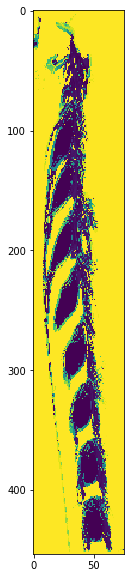

In [147]:
frac = subtreeSize/subtreeSizeOnes
plt.figure(figsize=(10,10))
plt.imshow(frac[:,:,30])

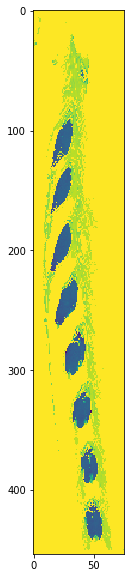

In [163]:
# Examine...
current = frac
plt.figure(figsize=(10,10))
loglog = np.log(np.log(current[:,:,30]+1))
log1 = np.log(current[:,:,30]+1)
thresh_copy = np.copy(log1)
#thresh_copy[thresh_copy < threshold_otsu(thresh_copy)] = 0
plt.imshow(thresh_copy)
#plt.imshow(log1)

In [158]:
offsets = make_offsets(3, True)
subtreeSize = np.copy(img)
#subtreeSize = np.power(np.array(down3,'float'),10)
subtreeSizeOnes = np.ones(down3.shape)
len_i = len(indices)
for i in range(len_i):
    if i % 100000 == 0:
        print(str(round(100*i/len_i,2)),"percent")
    current_index = tuple(indices[i])
    pred = indices[i] - offsets[traceback_array[current_index]]

    pred_index = tuple(pred)
    subtreeSize[pred_index] = max(subtreeSize[pred_index],subtreeSize[current_index])
    subtreeSizeOnes[pred_index] = max(subtreeSizeOnes[pred_index],subtreeSizeOnes[current_index]+1)
    #subtreeSize[current_index] += subtreeSize[tuple(pred)]

0.0 percent
4.03 percent
8.05 percent
12.08 percent
16.1 percent
20.13 percent
24.15 percent
28.18 percent
32.2 percent
36.23 percent
40.25 percent
44.28 percent
48.3 percent
52.33 percent
56.35 percent
60.38 percent
64.4 percent
68.43 percent
72.46 percent
76.48 percent
80.51 percent
84.53 percent
88.56 percent
92.58 percent
96.61 percent


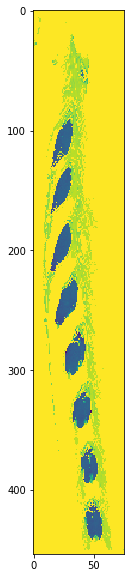

In [169]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(subtreeSize[:,:,30]))

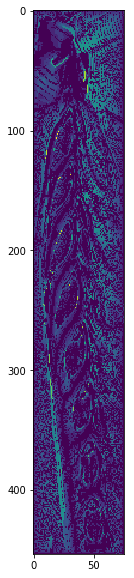

In [170]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(subtreeSizeOnes[:,:,30]))

In [ ]:
##################
#################

In [ ]:
#plt.hist(list(np.log(np.log(subtreeSize).flatten())))
plt.hist(list(np.log(subtreeSize).flatten()))
#

In [ ]:
plt.hist(list(subtreeSize.flatten()))

In [ ]:
plt.hist(list(down3.flatten()))

In [ ]:
pred = indices[i] - offsets[traceback_array[current_index]]

In [ ]:
pred

In [ ]:
subtreeSize[tuple(pred)]

In [ ]:
offsets = make_offsets(3, True)
offsets[traceback_array[tuple(indices[0])]] - indices[0]

In [ ]:
# All paths????
'''B = np.zeros(img.shape)

for i in range(0,img.shape[0],10):
    print(i)
    for j in range(img.shape[1]):
        for k in range(img.shape[2]):
            for pair in m.traceback([i,j,k]):
                B[pair] += 1
                
                '''
plt.figure(figsize=(10,10))

plt.imshow(B[:,:,30])